Extra Trees Model for Building Destruction Classification

In [1]:
#Import some basic packages
import numpy as np
import pandas as pd


In [2]:
#Import sklearn packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score


We start by reading data in from the cal_fire_data_cleaned CSV file:

In [3]:
#Let's import the data and instantiate a train/test split with the seed we fixed.

cal_fire_data = pd.read_csv('../data/cal_fire_data_cleaned.csv')
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

We set our feature and target variables and create a train/test split (80%/20%):

In [4]:

X = cal_fire_data.drop(columns='Destroyed')
y = cal_fire_data['Destroyed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=216, shuffle=True, stratify=y)


We create a pipeline for one-hot encoding the categorical variables, scaling the numeric variables, and running an extra trees model:

In [5]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference(['Destroyed'])

original_columns = cal_fire_data.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('scaler', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'  
)

etpipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(n_estimators=100, random_state=216))
])


We create a grid of hyperparameters that we want to test for our extra trees model:

In [6]:
param_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}


For this model, we perform a grid search that trains an extra trees model on the features, determining the best hyperparameters from our grid to use by determining which gives the best accuracy under k-fold cross-validation. Then, we classify each test observation by applying the best extra trees model.

In [7]:

grid_search_et = GridSearchCV(etpipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_et.fit(X_train, y_train)

print("best_params:", grid_search_et.best_params_)
y_etpred = grid_search_et.best_estimator_.predict(X_test)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
best_params: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 8}


Along with the prediction accuracy, we have a classification report that includes precision, recall, and f1 scores:

In [8]:
print("accuracy: ", accuracy_score(y_test, y_etpred))
print("\nreport: \n")
print(classification_report(y_test, y_etpred))


accuracy:  0.8663239074550129

report: 

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      5115
           1       0.88      0.77      0.82      3443

    accuracy                           0.87      8558
   macro avg       0.87      0.85      0.86      8558
weighted avg       0.87      0.87      0.86      8558



We also have a confusion matrix showing how the model performed across classes:

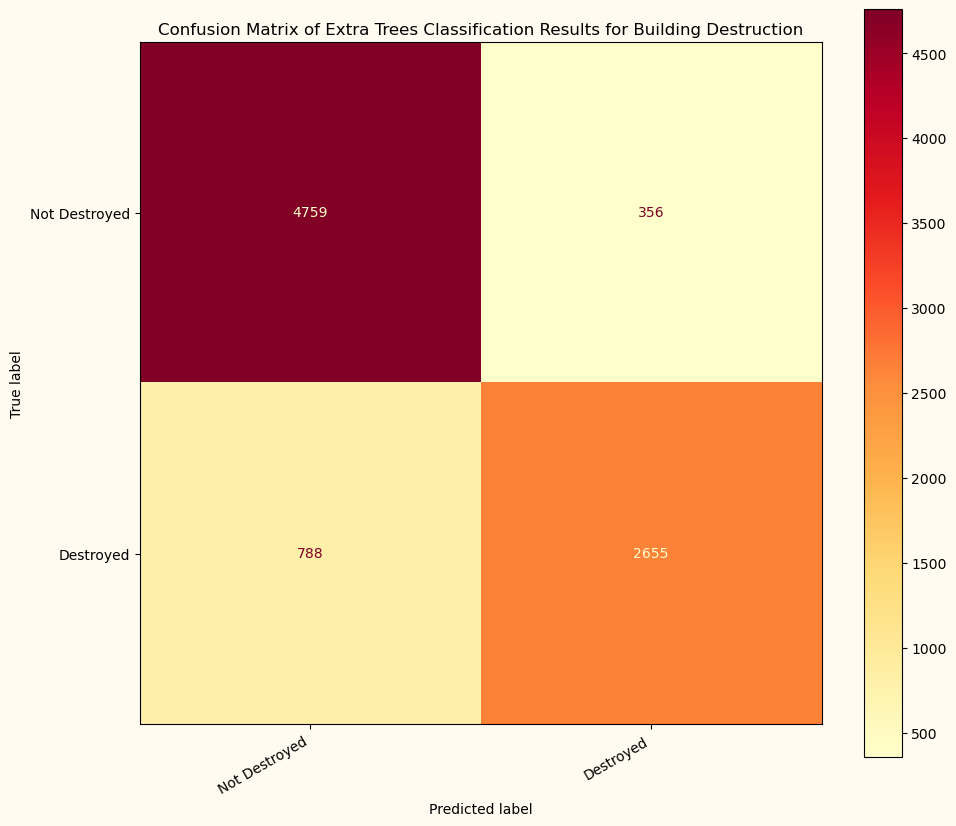

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_et = grid_search_et.best_estimator_
cm = confusion_matrix(y_test, y_etpred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(11, 11), facecolor = ('#fffbf0'))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.title("Confusion Matrix of Extra Trees Classification Results for Building Destruction")
plt.show()


It's clear that the regular Random Forest Classifier offers much better performance than this one, so we won't investigate feature removal.

We display feature importances for this model:

In [12]:
from IPython.display import display

# Use impurity-based feature importance (sum across all encodings for each feature)
importances = np.zeros(14)
importances[0] = np.sum(best_et['classifier'].feature_importances_[0:16])
importances[1] = np.sum(best_et['classifier'].feature_importances_[16:22])
importances[2] = np.sum(best_et['classifier'].feature_importances_[22:25])
importances[3] = np.sum(best_et['classifier'].feature_importances_[25:29])
importances[4] = np.sum(best_et['classifier'].feature_importances_[29:37])
importances[5] = np.sum(best_et['classifier'].feature_importances_[37:40])
importances[6] = np.sum(best_et['classifier'].feature_importances_[40:44])
importances[7] = np.sum(best_et['classifier'].feature_importances_[44:48])
importances[8] = np.sum(best_et['classifier'].feature_importances_[48:51])
importances[9] = np.sum(best_et['classifier'].feature_importances_[51:54])
importances[10:,] = best_et['classifier'].feature_importances_[54:58]

# Create a new dataframe for feature importances across original feature columns and display it
feature_df = pd.DataFrame({'feature': original_columns[:-1], 'importance': importances})
display(feature_df)


,feature,importance
0,* Structure Type,0.061844
1,* Roof Construction,0.043108
2,* Eaves,0.026809
3,* Vent Screen,0.039496
4,* Exterior Siding,0.440180
5,* Window Pane,0.021306
6,* Deck/Porch On Grade,0.021559
7,* Deck/Porch Elevated,0.019803
8,* Patio Cover/Carport Attached to Structure,0.018768
9,* Fence Attached to Structure,0.032648


For this model, the most important features were exterior siding and longitude.